# Apresentação desse notebook - Por Michelle Rodrigues

### Comparação de Modelos de Aprendizado de Máquinas para problemas de classificação em texto

## Meu Checklist Tarefas
Meu Checklist tarefas é uma aplicação onde o usuário pode acompanhar as tarefas de acordo com suas recorrências.
Na primeira entreva do MVP, entreguei um website com o painel do usuário, onde o usuário novo respondia algumas perguntas e essas perguntas listavam as tarefas elegíveis para seu estilo de vida.
Essas tarefas pertenciam a categorias e essas as categorias organizavam seus cards no painel.

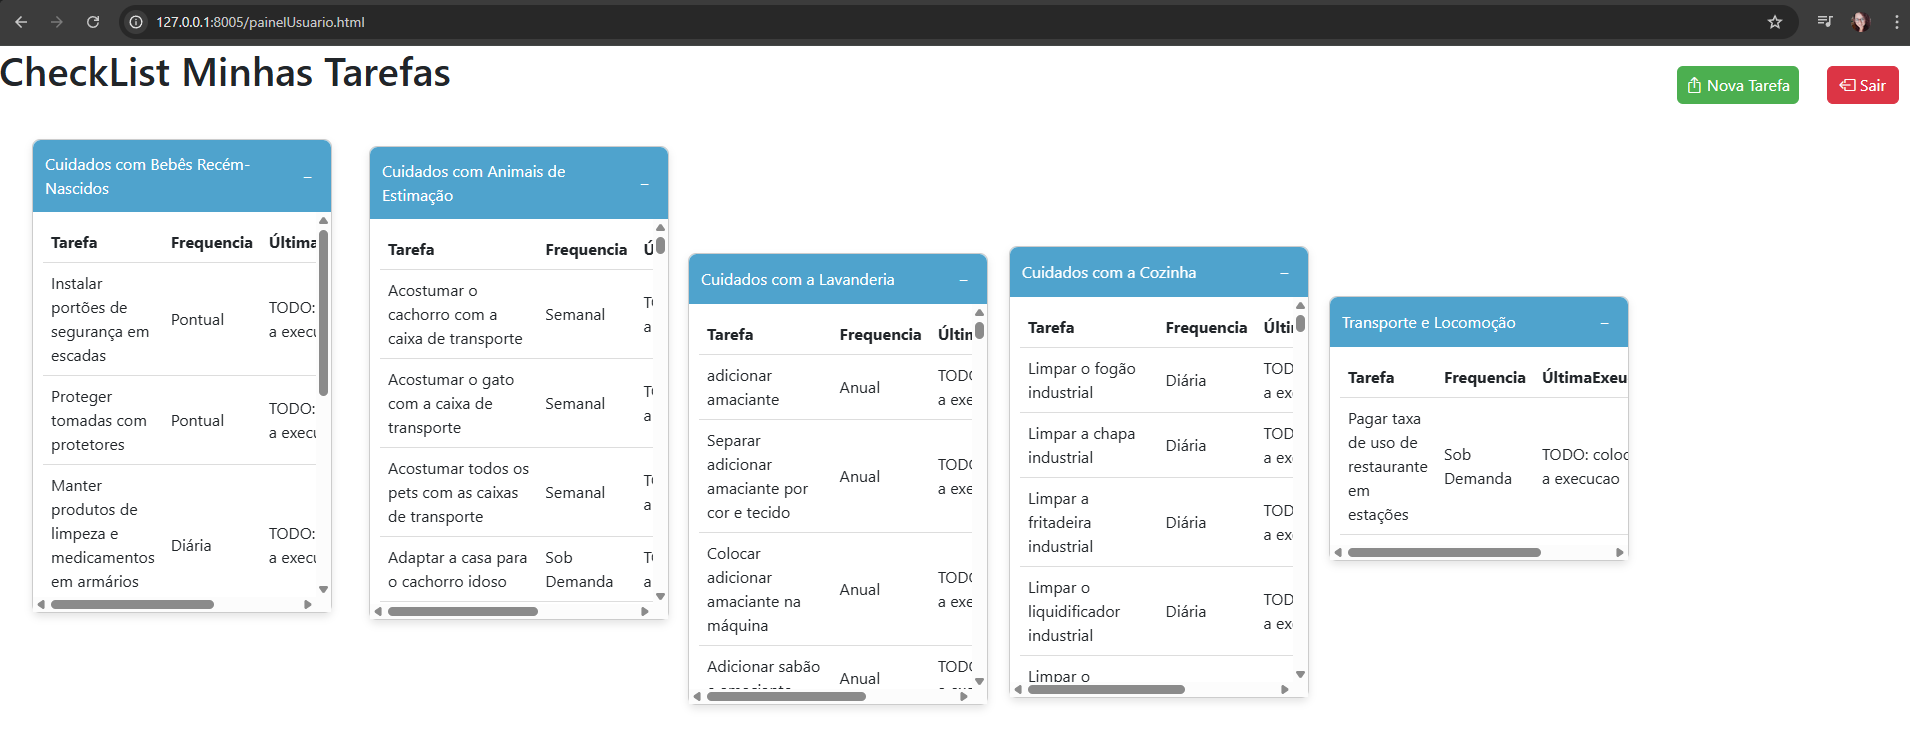

Inicialmente, o usuário começava sua jornada apenas com a resposta inicial do questionário, para "popular" seu painel.

Com esta segunda entrega, decidi promover o Software Inteligente onde o usuário pode cadastrar uma tarefa e o algoritmo prevê automaticamente a categoria para a tarefa digitada. Facilitando a vida do usuário.

Caso a categoria não seja satisfatória, ainda assim, o usuário pode selecionar a categoria disponível (ainda não está liberada o cadastro de novas categorias)

Uma vez inserida a tarefa, ela aparecerá na categoria correta, disponível no painel do usuário.

Para atender ao modelo de classificação, está disponível um arquivo .csv com cerca de 10k tarefas classificadas em suas categorias.

https://raw.githubusercontent.com/michellerodrigues/meu-checklist-tarefas-api/refs/heads/main/dataset_tarefas.csv


<div class="markdown-google-sans">
  <h2>1 - Configurações iniciais e Imports</h2>
</div>

In [1]:
"""1 - Configurações iniciais e Imports"""
from __future__ import annotations

import time
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

nltk.download('stopwords')
stop_words_pt = stopwords.words('portuguese')

print(f"Configurações iniciais realizadas com sucesso!")
print(f"Stop Words configuradas: {stop_words_pt}")
print(f"================> Vá para passo '2 - Montagem do Dataset' ====================>")


Configurações iniciais realizadas com sucesso!
Stop Words configuradas: ['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'ho

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<div class="markdown-google-sans">
  <h2>2 - Montagem do Dataset</h2>
</div>

In [2]:
"""2 - Montagem do Dataset"""

class DatasetTarefas:
    """Definição da classe que vai ser o nosso dataset"""
    def __init__(self):
        self.tarefa = []
        self.categoria = []

    def to_dict(self):
        return {'tarefa': self.tarefa, 'categoria': self.categoria}


def obter_dataset() -> DatasetTarefas:
    """Obtém o dataset do arquivo CSV remoto e retorna como DatasetTarefas"""
    dataset = DatasetTarefas()

    # URL do dataset (raw, github)
    url_dados = 'https://raw.githubusercontent.com/michellerodrigues/meu-checklist-tarefas-api/refs/heads/main/dataset_tarefas.csv'

    try:
        df = pd.read_csv(url_dados)

        if 'tarefa' in df.columns and 'categoria' in df.columns:
            dataset.tarefa = df['tarefa'].tolist()
            dataset.categoria = df['categoria'].tolist()

            print(f"Tipo do DataFrame: {type(df)}")
            print("\nPrimeiras 5 linhas do dataset:")
            print(df.head())
        else:
            raise ValueError("O CSV não contém as colunas esperadas ('tarefa' e 'categoria')")

    except Exception as e:
        print(f"Erro ao carregar dataset: {str(e)}")
        raise

    return dataset

dataset = obter_dataset()
print(f"Definição do Dataset realizada com sucesso")
print(f"================> Vá para passo '3 - Processamento dos dados' ====================>")


Tipo do DataFrame: <class 'pandas.core.frame.DataFrame'>

Primeiras 5 linhas do dataset:
                                     tarefa                          categoria
0                            Trocar fraldas  Cuidados com Bebês Recém-Nascidos
1  Limpar o bumbum com algodão e água morna  Cuidados com Bebês Recém-Nascidos
2              Passar pomada para assaduras  Cuidados com Bebês Recém-Nascidos
3                 Verificar se há assaduras  Cuidados com Bebês Recém-Nascidos
4                      Separar fralda limpa  Cuidados com Bebês Recém-Nascidos
Definição do Dataset realizada com sucesso
================> Vá para passo '3 - Processamento dos dados' ====================>


<div class="markdown-google-sans">
  <h2>3 - Processamento dos dados</h2>
</div>

In [3]:
"""3 - Pré-Processamento dos dados"""

print('\nINICIO pré-processamento')

# Criação do DataFrame
print('\nCriando DataFrame...')
df = pd.DataFrame(dataset.to_dict())

# Pré-processamento
print('\nPré-processamento dos dados...')
le = LabelEncoder()
df['categoria_encoded'] = le.fit_transform(df['categoria'])

# Divisão treino-teste
X_train, X_test, y_train, y_test = train_test_split(
    df['tarefa'],
    df['categoria_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=df['categoria_encoded'],
)

print('\nDivisão treino-teste...')

print('\nFIM pré-processamento')



# Função para avaliar modelos
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    start_time = time.time()

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"\n{model_name} - Cross-validation scores: {cv_scores}")
    print(f"{model_name} - Média CV accuracy: {np.mean(cv_scores):.4f}")

    # Treino e teste
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))

    print(f"{model_name} - Acurácia no treino: {train_acc:.4f}")
    print(f"{model_name} - Acurácia no teste: {test_acc:.4f}")

    # Relatório de classificação
    y_pred = model.predict(X_test)
    print(f"\nRelatório de classificação para {model_name}:")
    print(
        classification_report(y_test, y_pred, zero_division=0,
                              target_names=le.classes_),
    )

    print(f"Tempo de execução: {time.time() - start_time:.2f} segundos")

    return {
        'model': model,
        'name': model_name,
        'cv_mean': np.mean(cv_scores),
        'train_acc': train_acc,
        'test_acc': test_acc,
        'time': time.time() - start_time,
    }

print(f"================> Vá para passo '4 - Definição dos modelos de Algoritmo a serem testados' ====================>")


INICIO pré-processamento

Criando DataFrame...

Pré-processamento dos dados...

Divisão treino-teste...

FIM pré-processamento
================> Vá para passo '4 - Definição dos modelos de Algoritmo a serem testados' ====================>


<div class="markdown-google-sans">
  <h2>4 - Definição dos modelos de Algoritmo a serem testados</h2>
</div>

In [4]:
""" 4 - Definição dos modelos de Algoritmo a serem testados """

print('\nINICIO===> Definindo os modelos')

models = [
    (
        'Naive Bayes',
        make_pipeline(TfidfVectorizer(stop_words=stop_words_pt),
                      MultinomialNB()),
    ),
    (
        'KNN',
        make_pipeline(
            TfidfVectorizer(stop_words=stop_words_pt),
            StandardScaler(with_mean=False),
            KNeighborsClassifier(),
        ),
    ),
    (
        'Árvore de Decisão',
        make_pipeline(
            TfidfVectorizer(stop_words=stop_words_pt),
            DecisionTreeClassifier(random_state=42),
        ),
    ),
    (
        'SVM',
        make_pipeline(
            TfidfVectorizer(stop_words=stop_words_pt),
            StandardScaler(with_mean=False),
            SVC(probability=True, random_state=42),
        ),
    ),
]

print('\n FIM ===> Modelos definidos com sucesso')
print(f"================> Vá para passo '5 - Otimização de hiperparâmetros para cada modelo:' ====================>")


INICIO===> Definindo os modelos

 FIM ===> Modelos definidos com sucesso
================> Vá para passo '5 - Otimização de hiperparâmetros para cada modelo:' ====================>


<div class="markdown-google-sans">
  <h2>5 - Otimização de hiperparâmetros para cada modelo:</h2>

    # Para 'Naive Bayes' vamos testar 4 formas de 'suavização' para o alpha
    #     (Laplace smoothing) ==> Quanto mais alto (2.0), mais suavização
    #     e evita probabilidade zero caso a tarefa não se encaixe em
    #     nenhuma categoria ou não esteja presente no modelo de treinamento.

    # Para 'KNN' vamos testar com os vizinhos 3, 5 e 7 mais próximos.
    #     n_neighbors: Número de vizinhos a considerar (Quanto maior o número
    #     de vizinhos (7), mais 'justo' de advinhar)
    #     Para esses 3 parâmetros, vamo considera o peso (como esses vizinhos
    #     contribuem para a classificação, Sendo: uniform (todos com peso igual)
    #     distance (Vizinhos mais próximos têm maior peso)
    #     OU seja, serão 6 combinações para o KNN.

    # Para 'Árvore de Decisão' (orienta-se por 'perguntas'/caminhos de decisão)
    #     vamos testar com as profundidades (max_depth) None, 10,20,30
    #     Sendo assim, 'None' pode fazer quantas perguntas forem necessárias
    #     até não ter mais tarefas para perguntar
    #     Esgota-se as 'perguntas'. Já com 10,20 ou 30 , essas seriam
    #     as profundidades, mesmo que não tenha certeza, pararia na 10a 'pergunta'
    #     em min_samples_split, consideramos quantas tarefas diferentes devem
    #     estar no mesmo grupo para fazermos novas perguntas e tomar decisões
    #      com base nessas respostas

    # Para 'SVM' (Um C médio (1, tolerancia ideal de erros de classificação.
    #      0.1 mais tolerante, 10 mais rigoroso) com kernel linear para
    #      verificar as categorias que são separáveis por palavras-chave
    #      específicas, por exemplo:
    #           trocar frauda do bebê (Cuidado com bebês) e
    #           trocar frauda idoso acamado (Cuidado com Idosos)
    #      O kernel rbf para verificar relações complexas por exemplo:
    #           trocar protetor de cama pode ser tanto para idoso
    #           quanto para bebês.


</div>

In [5]:
"""5 - Otimização de hiperparâmetros para cada modelo """

print('\n INICIO ===> Declaração dos Params Grid')

param_grids = {
    'Naive Bayes': {'multinomialnb__alpha': [0.1, 0.5, 1.0, 2.0]},
    'KNN': {
        'kneighborsclassifier__n_neighbors': [3, 5, 7],
        'kneighborsclassifier__weights': ['uniform', 'distance'],
    },
    'Árvore de Decisão': {
        'decisiontreeclassifier__max_depth': [None, 10, 20, 30],
        'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    },
    'SVM': {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']},
}

print('\n FIM ===> Params Grid declarado com sucesso')
print(f"================> Vá para passo '6 - Treinamento e avaliação dos modelos:' ====================>")


 INICIO ===> Declaração dos Params Grid

 FIM ===> Params Grid declarado com sucesso
================> Vá para passo '6 - Otimização de hiperparâmetros para cada modelo:' ====================>


<div class="markdown-google-sans">
  <h2>6 - Treinamento e avaliação dos modelos</h2>

GridSearchCV vai ser responsável por fazer as combinações dos parâmetros
de cada algoritmo configurado, avaliando o melhor resultado para quais
parâmetros usar. Por exemplo: para o SVN, serão 3 valores de C × 2 kernels = 6 combinações totais)
Para cada combinação (p. ex: C=0,1 x Kernel linear) será feita uma validação
cruzada onde o conjunto será treinado 4x e testado na 5a vez(fold cv=5).
Avaliando qual foi o melhor resultado)

  <div>

In [12]:
""" 6 - Treinamento e avaliação dos modelos """

print('\n INICIO ===> Processamento do Modelo ')

results = []
best_models = {}

for name, model in models:
    print(f"\n=== Processando modelo: {name} ===")

    # GridSearchCV para otimização de hiperparâmetros
    grid_search = GridSearchCV(model, param_grids[name], cv=5, n_jobs=-1, verbose=1)

    print(f"Otimizando hiperparâmetros para {name}...")
    grid_search.fit(X_train, y_train)

    print(f"Melhores parâmetros para {name}: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    best_models[name] = best_model

    # Avaliação do melhor modelo
    result = evaluate_model(
        best_model, X_train, y_train, X_test, y_test, f"{name} (Otimizado)",
    )
    results.append(result)


print('\n INICIO ===> Processamento do Modelo ')
print(f"================> Vá para passo '7 - Comparação e Visualização dos Resultados do modelo' ====================>")


 INICIO ===> Processamento do Modelo 

=== Processando modelo: Naive Bayes ===
Otimizando hiperparâmetros para Naive Bayes...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Melhores parâmetros para Naive Bayes: {'multinomialnb__alpha': 0.1}

Naive Bayes (Otimizado) - Cross-validation scores: [0.90775558 0.89189189 0.88836663 0.87184009 0.89594356]
Naive Bayes (Otimizado) - Média CV accuracy: 0.8912
Naive Bayes (Otimizado) - Acurácia no treino: 0.9550
Naive Bayes (Otimizado) - Acurácia no teste: 0.9037

Relatório de classificação para Naive Bayes (Otimizado):
                                        precision    recall  f1-score   support

     Cuidados com Animais de Estimação       0.90      0.97      0.94       251
     Cuidados com Bebês Recém-Nascidos       0.89      0.88      0.89       188
                   Cuidados com Idosos       0.89      0.85      0.87       356
                  Cuidados com Plantas       0.98      0.98      0.98       354
Cuidados com a Casa 

**7 - Comparação e Visualização dos Resultados do modelo**

In [7]:
"""7 - Comparação e Visualização dos Resultados do modelo """

print('\n INICIO ===> Comparação dos Modelos')

comparison = pd.DataFrame(results)
print(comparison[['name', 'cv_mean', 'train_acc', 'test_acc', 'time']])

print('\n FIM ===> Comparação dos Modelos')

print('\n INICIO ===> Visualização dos resultados')
# Visualização dos resultados
plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='test_acc', data=comparison)
plt.title('Acurácia nos Testes por Modelo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('comparacao_modelos.png')
plt.close()

print('\n FIM ===> Visualização dos resultados')
print(f"================> Vá para passo '8 - Proposta para melhorias nos dados' ====================>")


 INICIO ===> Comparação dos Modelos
                            name   cv_mean  train_acc  test_acc        time
0        Naive Bayes (Otimizado)  0.891160   0.954984  0.903665    0.663819
1                KNN (Otimizado)  0.779854   0.994358  0.802632    4.915474
2  Árvore de Decisão (Otimizado)  0.851198   0.994358  0.857613    2.508891
3                SVM (Otimizado)  0.868357   0.991772  0.886748  130.658123

 FIM ===> Comparação dos Modelos

 INICIO ===> Visualização dos resultados

 FIM ===> Visualização dos resultados
================> Vá para passo '8 - Proposta para melhorias nos dados' ====================>


<div class="markdown-google-sans">
  <h2>8 - Ensemble com os melhores modelos</h2>

Abaixo uma proposta de Ensemble com a votação dos melhores modelos
onde a média da soma dos percentuais de cada categoria será considerada para
a classificação.
  <div>

In [8]:
"""8 - Ensemble com os melhores modelos"""

print('\n INICIO ===> Criando ensemble com os melhores modelos...')

ensemble = VotingClassifier(
    estimators=[(name, model) for name, model in best_models.items()], voting='soft',
)

ensemble_result = evaluate_model(ensemble, X_train, y_train, X_test, y_test, 'Ensemble')
results.append(ensemble_result)

print('\n FIM ===> Ensemble com os melhores modelos criado com sucesso ...')


 INICIO ===> Criando ensemble com os melhores modelos...

Ensemble - Cross-validation scores: [0.91833137 0.91421857 0.90775558 0.89417989 0.91181658]
Ensemble - Média CV accuracy: 0.9093
Ensemble - Acurácia no treino: 0.9944
Ensemble - Acurácia no teste: 0.9206

Relatório de classificação para Ensemble:
                                        precision    recall  f1-score   support

     Cuidados com Animais de Estimação       0.97      0.97      0.97       251
     Cuidados com Bebês Recém-Nascidos       0.90      0.89      0.90       188
                   Cuidados com Idosos       0.90      0.91      0.91       356
                  Cuidados com Plantas       0.97      0.99      0.98       354
Cuidados com a Casa (Manutenção Geral)       0.80      0.63      0.71       105
                Cuidados com a Cozinha       0.89      0.88      0.88       243
             Cuidados com a Lavanderia       0.96      0.98      0.97       200
                   Limpeza do Banheiro       0.91   

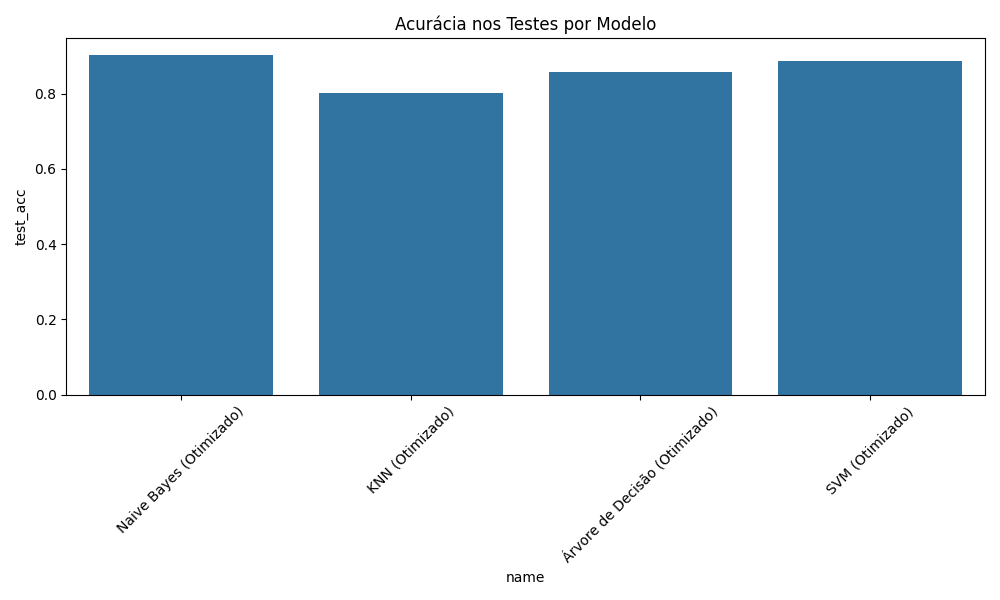

9 - Predição de Categoria Usilizando o Ensenble

Apesar de estamos aplicando o limite threshold de 45% futuramente podemos adaptar para utilizar um threshold específico que melhor se adapta para cada categoria.

Caso a probabilidade seja menor que o threshold, a categoria será devolvida como 'Outros'. (Na tela, o usuário pode selecionar outra categoria)


In [10]:

"""9 - Predição de Categoria Utilizando o Ensenble"""

print('\n INICIO ===> Predição de Categoria Utilizando o Ensenble')

# Função para prever categoria com threshold
def prever_categoria_ensenble(tarefa, threshold=0.45):
    probas = ensemble.predict_proba([tarefa])[0]
    max_proba = max(probas)

    if max_proba < threshold:
        return 'Outros'

    encoded = ensemble.predict([tarefa])[0]
    return le.inverse_transform([encoded])[0]

print('\n INICIO ===> Definindo alguns casos de teste para verificar retorno')

# Exemplos de uso
test_cases = [
    'substituir escovas de dente',
    'instalar sistema de irrigação das plantas',
    'organizar calendário de provas',
    'Comprar protetor de colchão para idosos',
    'recarregar o bilhete do metrô',
]

print('\n SIM ===> Casos de teste para definidos com sucesso')


print('\nTestando o modelo ensemble:')
for task in test_cases:
    print(f"A tarefa '{task}' pertence à categoria: {prever_categoria_ensenble(task)}")


print('\n FIM ===> Predição de Categoria Utilizando o Ensenble')


 INICIO ===> Predição de Categoria Utilizando o Ensenble

 INICIO ===> Definindo alguns casos de teste para verificar retorno

 SIM ===> Casos de teste para definidos com sucesso

Testando o modelo ensemble:
A tarefa 'substituir escovas de dente' pertence à categoria: Limpeza do Banheiro
A tarefa 'instalar sistema de irrigação das plantas' pertence à categoria: Cuidados com Plantas
A tarefa 'organizar calendário de provas' pertence à categoria: Limpeza do Banheiro
A tarefa 'Comprar protetor de colchão para idosos' pertence à categoria: Outros
A tarefa 'recarregar o bilhete do metrô' pertence à categoria: Transporte e Locomoção

 FIM ===> Predição de Categoria Utilizando o Ensenble


10 - Escolha dos melhores modelos

In [14]:
# Identifica automaticamente o melhor modelo individual
comparison['rank_test_acc'] = comparison['test_acc'].rank(ascending=False)
melhor_individual = comparison[comparison['rank_test_acc'] == 1]['name'].values[0]

print(f"\nMelhor modelo individual: {melhor_individual}")
print(f"Acurácia no teste: {comparison[comparison['name'] == melhor_individual]['test_acc'].values[0]:.4f}")

# Compara com o ensemble
acuracia_ensemble = ensemble_result['test_acc']
print(f"\nAcurácia do Ensemble: {acuracia_ensemble:.4f}")

if acuracia_ensemble > comparison[comparison['name'] == melhor_individual]['test_acc'].values[0]:
    print("O Ensemble superou todos os modelos individuais!")
else:
    print("O melhor modelo individual teve performance similar ao Ensemble")

Melhor modelo individual: Naive Bayes (Otimizado)

Melhor modelo individual: Naive Bayes (Otimizado)
Acurácia no teste: 0.9037

Acurácia do Ensemble: 0.9206
O Ensemble superou todos os modelos individuais!
